FilFinder Tutorial
==================

This tutorial demonstrates the FilFinder algorithm on a simulated data set. The updated algorithm from ```FilFinder2D``` is used here, which is valid for versions >1.5. This tutorial was tested with python 3.6.

The example data is included in the github repository [here](https://github.com/e-koch/FilFinder/blob/master/examples/filaments_updatedhdr.fits).

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.stats import sigma_clipped_stats

# Optional settings for the plots. Comment out if needed.
import seaborn as sb
sb.set_context('poster')

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12., 9.6)

Input Data
--------

There are two caveats to the input data:

1) All angular and physical conversions assume that pixels in the image can be treated as squares. `FilFinder2D` is not aware of any axis misalignments! If you're data does not have aligned celestial axes, we recommend reprojecting the data onto a square grid.

2) The beam size is characterized by the major axis, assuming a 2D Gaussian beam shape. If the beam size of your data is highly elliptical, it is recommended to convolve the data to a circular beam.

```FilFinder2D``` accepts several input types, including a FITS HDU and numpy arrays.

In [20]:
from fil_finder import FilFinder2D
from astropy.io import fits

Galaxy = "ngc0628"
intScale = "032"
scale_pc = int(intScale)
pc_pix = 5.24
factor = .1 #factor controls masking thresholds

image_path = rf"C:\Users\HP\Documents\JHU_Academics\Research\Soax_results_blocking_V2\{Galaxy}\{Galaxy}_F770W_starsub_anchored.fits_CDDss0{intScale}pc_arcsinh0p1.fits"

hdu = fits.open(image_path)[0]

fil = FilFinder2D(hdu)

# HDU data as an array
arr = hdu.data
arr = arr
hdr = hdu.header

fil = FilFinder2D(arr)

c:\Users\HP\Documents\JHU_Academics\Research\PHANGS\PHANGSDustFill\FilFinder\examples\fil_finder\base_conversions.py:55: UserWarning: Cannot find 'BMAJ' in the header. Try installing the `radio_beam` package for loading header information.
  warn("Cannot find 'BMAJ' in the header. Try installing"
c:\Users\HP\Documents\JHU_Academics\Research\PHANGS\PHANGSDustFill\FilFinder\examples\fil_finder\base_conversions.py:63: UserWarning: Cannot find 'BMIN' in the header. Assuming circular beam.
  warn("Cannot find 'BMIN' in the header. Assuming circular beam.")
c:\Users\HP\Documents\JHU_Academics\Research\PHANGS\PHANGSDustFill\FilFinder\examples\fil_finder\base_conversions.py:69: UserWarning: Cannot find 'BPA' in the header. Assuming PA of 0.
  warn("Cannot find 'BPA' in the header. Assuming PA of 0.")
c:\Users\HP\Documents\JHU_Academics\Research\PHANGS\PHANGSDustFill\FilFinder\examples\fil_finder\filfinder2D.py:142: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam widt

In [21]:

fil = FilFinder2D(arr, distance=9.84* u.pc, ang_scale=0.11 * u.deg)

Image Preprocessing
-----------------

Prior to creating the mask, it can be helpful to first *flatten* the image of bright compact sources. `FilFinder2D` uses an arctan transform, where the data are first normalized by some percentile value of the data:

In [22]:
# fil.preprocess_image(flatten_percent=95)
fil.preprocess_image(skip_flatten = True) #Scale decomposed is already flattened

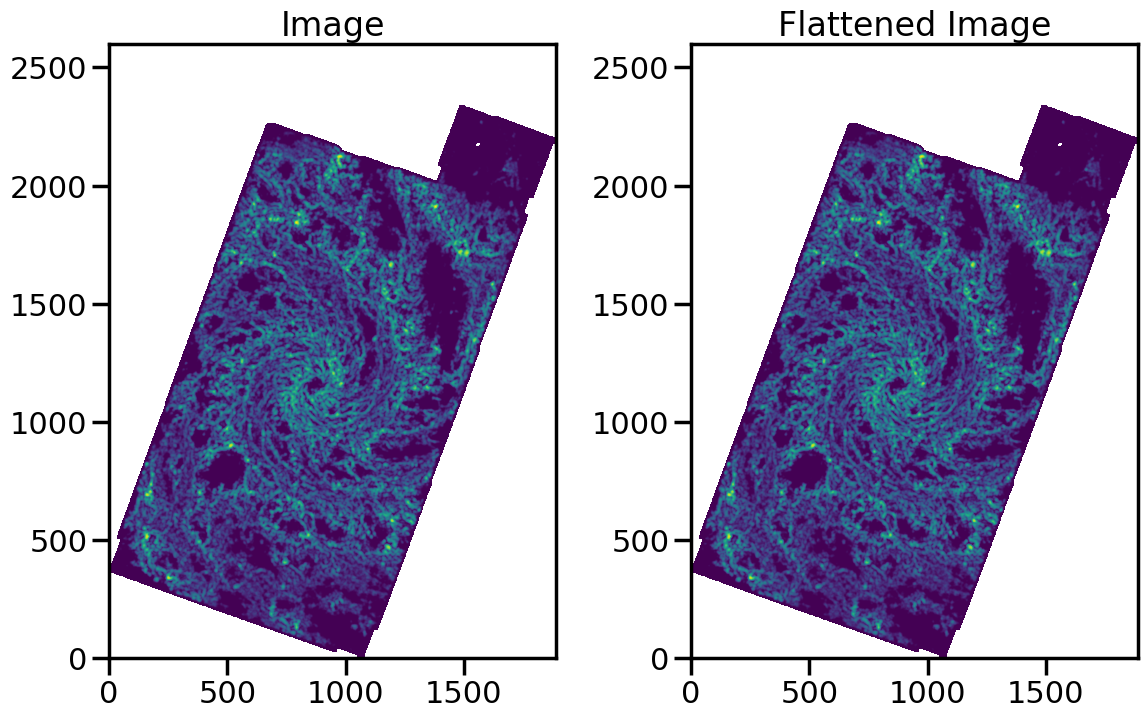

In [23]:
plt.subplot(121)
plt.imshow(fil.image.value, origin='lower')
plt.title("Image")
plt.subplot(122)
plt.imshow(fil.flat_img.value, origin='lower')
plt.title("Flattened Image")
plt.tight_layout()

If a percentile is not given, `FilFinder2D.preprocess_image` will try to fit a log-normal distribution to the data and will set the threshold at $\mu + 2 \sigma$. **There are no checks for the quality of the fit. Use only if you are confident that the brightness distribution is close to a log-normal.**

If you wish to run the masking procedure without flattening the image, use the command: fil.preprocess_image(skip_flatten=True)

Masking
--------

Creating the filament mask is a complex process performed by `FilFinder2D.create_mask`. There are several parameters that set the masking behaviour.

If a FITS header and distance were provided at the beginning, `FilFinder2D` will use default guesses based on typical filament sizes from Herschel studies of the Gould Belt clouds (e.g., [Koch & Rosolowsky 2015](https://ui.adsabs.harvard.edu/#abs/2015MNRAS.452.3435K/abstract)). These choices will not be the optimal settings in general, and we recommend trying different different parameter setting before using the resulting mask for the analysis.

If a distance was not provided, these parameters must be set. `FilFinder2D` will raise errors until the required parameters are given.

This simulated data set is an example where the default `FilFinder2D` settings do not provide an ideal filament mask:

Most of the filamentary structure has been ignored by the mask. There are several parameters that can be set to improve the mask:

* `glob_thresh` -- Set a minimum intensity for a pixel to be included in the mask. This is useful for removing noisy regions in the data from the mask. Must have the same units as `fil.image`.
* `adapt_thresh` -- The width of the element used for the adaptive thresholding mask. This is primarily the step that picks out the filamentary structure. The element size should be similar to the width of the expected filamentary structure. The default here, when distance is provided, is 0.1 pc.
* `smooth_size` -- It is often helpful to smooth the data before calculating the mask. By smoothing in small scales, small noise variations are removed resulting in a simpler skeleton structure. The default is set to 0.05 pc.
* `size_thresh` -- The minimum number of pixels a region of the mask must have to be considered real. The default is set by assuming a minimum filament size to be an ellipse with a 0.1 pc width and length of 0.5 pc. *Most data sets will require this parameter to be manually set,* as is used below.
* `regrid` -- If the pixel width of `adapt_thresh` is less than 40 pixels, the resulting mask may be fragmented due to pixelization. To increase the size of `adapt_thresh`, `regrid` interpolates the data onto a larger grid, calculates the mask on the larger grid, then interpolates the mask at the original image size.
* `border_masking` -- Observational maps may not fill the entire image, and the edges of the mapped regions tend to be noisier. `border_masking` finds regions of `NaNs` along the edge of the map and tries to remove noisy regions near the edges. Its behaviour can be controlled using `border_kwargs`, where the size of a NaN region (`size`), size of the filter used to define noisy edges (`filt_width`), and the number of times to apply that filter (`eros_iter`) can be controlled.
* `fill_hole_size` -- If there are holes within a skeleton, `fill_hole_size` can be used to fill in holes smaller than the given size.
* `use_existing_mask` -- If you gave a user-defined mask when calling `FilFinder2D`, enable this parameter to skip making a new mask.

Varying a few of these parameters will produce a much improved mask. First, since the data go right to the edges of the image, we can disable `border_masking`:

glob_thresh: 0.1908658412526196


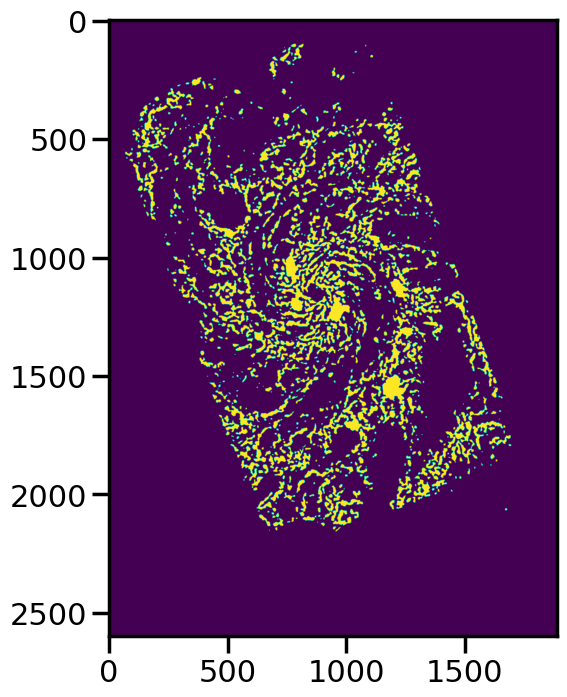

In [24]:
scale_pix = factor*scale_pc/pc_pix
# Calculate sky level and noise using sigma-clipping
mean, median, std_dev = sigma_clipped_stats(arr, sigma=3.0)

# Calculate 2 sigma above sky level
threshold_2sigma = factor*median + 2 * std_dev
print(f"glob_thresh: {threshold_2sigma}")
fil.create_mask(verbose=False, border_masking=True, size_thresh = 6*3.1415*scale_pix**2 * u.pix**2 , glob_thresh = threshold_2sigma, adapt_thresh = 2*scale_pix*u.pix, smooth_size = .5*scale_pix*u.pix, fill_hole_size = .5 * scale_pix**2 * u.pix **2)

mask = fil.mask  # The binary mask created by fil.create_mask()

# Plot the mask
plt.figure(figsize=(8, 8))
plt.imshow(mask)
plt.show()

Skeletonization
-----------------

The next step is to reduce the mask into single-pixel-width skeleton objects. These skeletons will define the location of a filament and its path.

In `FilFinder2D`, the [medial axis](http://scikit-image.org/docs/0.10.x/auto_examples/plot_medial_transform.html) is defined to be the skeleton:

Text(0.5, 1.0, 'Skeletonized filaments without any pruning')

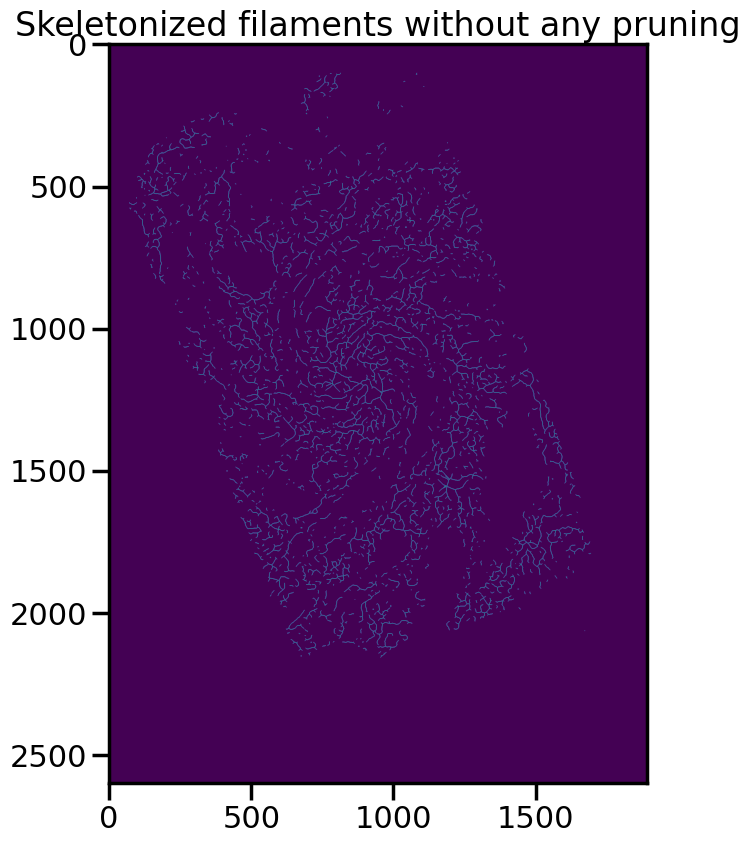

In [25]:
# import importlib
# importlib.reload(fil_finder.FilFinder2D)
fil.medskel(verbose=False)
plt.imshow(fil.skeleton)
plt.title('Skeletonized filaments without any pruning')

Skeletons: Pruning & Length
-------------------------------

We are now prepared to analyze the filaments. The first analysis step includes two parts: pruning the skeleton structures and finding the filament lengths. The first part removes small/unimportant spurs on the skeletons. To ensure important portions of the skeleton are retained, however, both parts are performed together.

Each skeleton is converted into a graph object using the [networkx](https://networkx.github.io/) package. We use the graph to find the longest path through the skeleton, which is used to define the structure's length. All branches in the skeleton away from this longest path are eligible to be pruned off.

This process is handled by the `FilFinder2D.analyze_skeletons` function. When using `verbose=True`, a ton of plots will get returned. To save you some scrolling, the verbose mode is highlighted for just one filament below.

With just the default settings:

The skeletons are largely the same, with only short branches removed.

The default settings use minimum skeleton and branch lengths based off of the beam size. To be kept, a branch must be at least three times the length of the beam and a skeleton must have a length of 5 times the beam. Practically, this will only remove very small features.

These parameters, and ones related to the pruning, can be manually set:

* `prune_criteria` -- The criteria for removing a branch can be altered. The default ('all') uses a mix of the average intensity along the branch and its length. The length alone can be used for pruning with `prune_criteria='length'`. All branches below this length will be removed. Finally, only the intensity can be used for pruning (`prune_criteria='intensity'`). A branch is kept in this case by comparing the average intensity along the branch to the average over the whole filament. The critical fraction that determines whether a branch is important is set by `relintens_thresh`.
* `relintens_thresh` -- Set the critical intensity comparison for intensity-based pruning.
* `nbeam_lengths` -- Number of beam widths a skeleton must have to be considered a valid structure. Default is 5.
* `branch_nbeam_lengths` -- Number of beam widths a branch must have to avoid pruning. Default is 3.
* `skel_thresh` -- Minimum length for a skeleton. Overrides `nbeam_lengths`. Must have a unit of length.
* `branch_thresh` -- Minimum length for a branch. Overrides `branch_nbeam_lengths`. Must have a unit of length.
* `max_prune_iter` -- Number of pruning iterations. The default is 10, which works well for multiple data sets used in the testing process. A warning is returned if the maximum is reached. **New in `FilFinder2D`!**

Here we will highlight the effect of pruning away moderately long branches. Note that re-running `FilFinder2D.analyze_skeletons` will start on the *output* from the previous call, not that original skeleton from `FilFinder2D.medskel`.

In [26]:

fil.analyze_skeletons(branch_thresh= 10 * u.pix,skel_thresh = 25*u.pix, prune_criteria='length')


c:\Users\HP\Documents\JHU_Academics\Research\PHANGS\PHANGSDustFill\FilFinder\examples\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


the MSSIM for FilFinder is: 0.5971
the MSSIM for FilPHANGS 33% Probability Thresh is: 0.9617
the MSSIM for FilPHANGS Blurred Composite: 0.5968


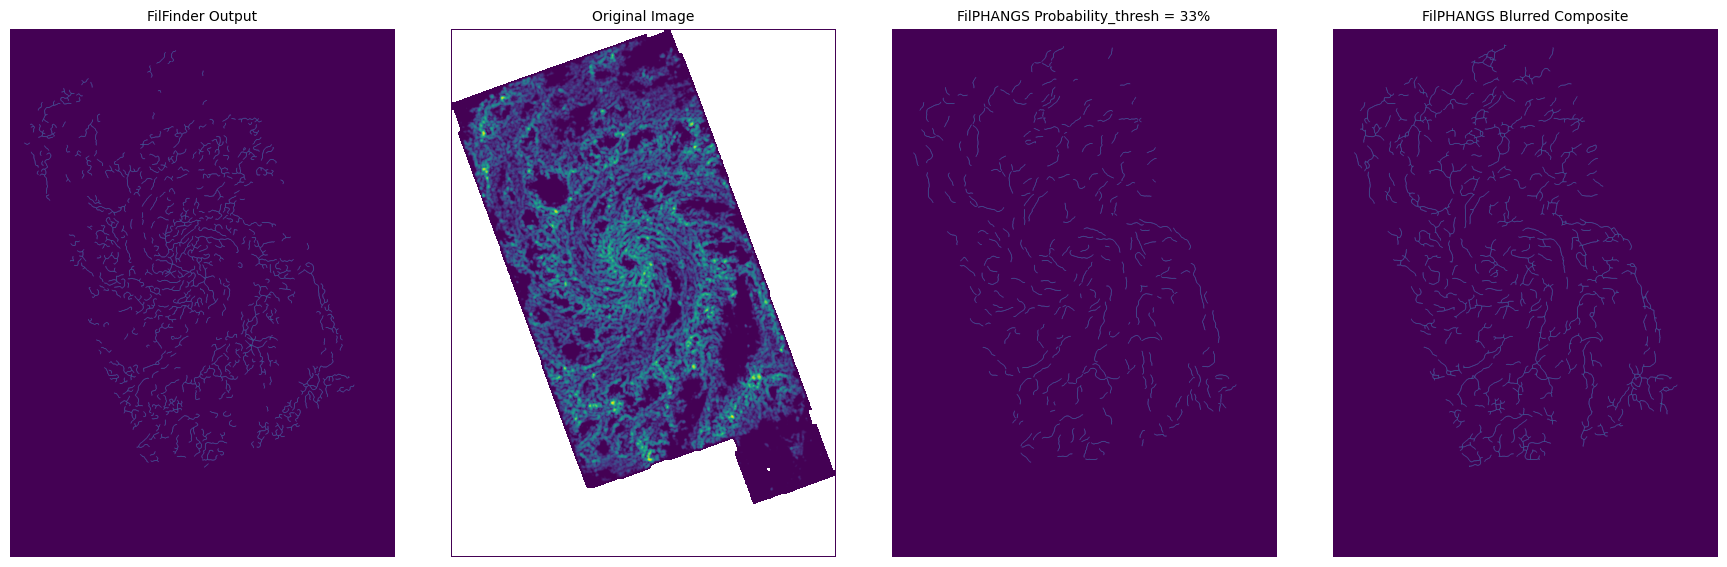

In [27]:
from skimage.metrics import structural_similarity as ssim
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize

def calculate_mssim(image1, image2):
    """
    Calculate the Mean Structural Similarity Index (MSSIM) between two images.
    
    Args:
        image1: The first input image (reference image).
        image2: The second input image (test image).
        
    Returns:
        mssim: The MSSIM score between the two images (ranges from -1 to 1).
    """
    # Ensure images are in the correct format (float32) and in the same shape
    image1 = image1.astype(np.float32)
    image2 = image2.astype(np.float32)
    image1[np.isnan(image1)] = 0
    image2[np.isnan(image2)] = 0

    #Replace nan with zero
    max = np.max((image1, image2))
    min = np.min((image1, image2))

    # Normalize images to be between 0 and 1...Is this step necessary? 
    # image1 = (image1 - np.min(image1)) / (np.max(image1) - np.min(image1))
    # image2 = (image2 - np.min(image2)) / (np.max(image2) - np.min(image2))

    # Compute MSSIM between the two images
    mssim_value, _ = ssim(image1, image2, data_range = max-min, full=True)

    return mssim_value

fil_MSSIM = round(calculate_mssim(arr, fil.skeleton), 4)
print(f'the MSSIM for FilFinder is: {fil_MSSIM}')


FilPHANGS_SKel_Path = rf"C:\Users\HP\Documents\JHU_Academics\Research\Soax_results_blocking_V2\{Galaxy}\Composite\{Galaxy}_F770W_starsub_anchored.fits_CDDss0{intScale}pc_arcsinh0p1_Composite_0.33.fits"
hdu = fits.open(FilPHANGS_SKel_Path)[0]
FilPHANGS_Skel = hdu.data
FilPHANGS_Skel[FilPHANGS_Skel > 0] = 255

filPHANGS_MSSIM = round(calculate_mssim(arr, FilPHANGS_Skel), 4)
print(f'the MSSIM for FilPHANGS 33% Probability Thresh is: {filPHANGS_MSSIM}')

FilPHANGS_SKel_Path = rf"C:\Users\HP\Documents\JHU_Academics\Research\Soax_results_blocking_V2\{Galaxy}\Composite\{Galaxy}_F770W_starsub_anchored.fits_CDDss0{intScale}pc_arcsinh0p1_CompositeBlur.fits"
hdu = fits.open(FilPHANGS_SKel_Path)[0]
FilPHANGS_Skel_Blur = hdu.data
FilPHANGS_Skel_Blur = skeletonize(FilPHANGS_Skel_Blur)
filPHANGS_MSSIM_Blur = round(calculate_mssim(arr, FilPHANGS_Skel_Blur), 4)
print(f'the MSSIM for FilPHANGS Blurred Composite: {filPHANGS_MSSIM_Blur}')


# Create a figure and a set of subplots (3 subplots in a row)
fig, axs = plt.subplots(1, 4, figsize=(18, 6))  # Increased figure size

# First subplot
axs[0].imshow(fil.skeleton)
axs[0].set_title('FilFinder Output', fontsize=10)  # Smaller title font
axs[0].axis('off')  # Remove axes

# Second subplot
axs[1].imshow(arr)
axs[1].set_title('Original Image', fontsize=10)
axs[1].axis('off')

# Third subplot
axs[2].imshow(FilPHANGS_Skel)
axs[2].set_title('FilPHANGS Probability_thresh = 33%', fontsize=10)
axs[2].axis('off')

#Fourth  subplot
axs[3].imshow(FilPHANGS_Skel_Blur)
axs[3].set_title('FilPHANGS Blurred Composite', fontsize=10)
axs[3].axis('off')
# Adjust layout to prevent overlap
plt.tight_layout()

# Show the figure
plt.show()

Quote from the MSSIM Paper(https://iopscience.iop.org/article/10.3847/2041-8213/aa6e50/pdf): 

"It could also be
used to find the best skeletal representations of the input image
independently of the algorithm. However, we urge caution in
that approach because filament identification algorithms
operate on different mathematical bases, implicitly defining
filaments in different ways. They also have different input
parameters and their skeletons may require different amounts of
post-processing before they meet the user’s definition of a
filament (e.g., in the removal of skeleton sections that are too
short to be a filament by the user’s definition) and before the
outputs from different algorithms are directly comparable.
Additionally, the MSSIM does not indicate that a skeleton and
the input parameters that created it are physically sensible, nor
does it indicate anything about the “goodness” or suitability of
an algorithm, or input image (e.g., in terms of noise properties),
for the purpose of filament identification. It only quantifies the
quality of the representation of the input image of the
corresponding skeleton."

**Caution should be taken in using the MSSIM to compare algorithms. Great that it os higher for FilPHANGS, but it definitely seems way too high. For many galaxies, FilPHANGS scores near unity.**

The paper also cites that small differences in MSSIM are sufficient and express genuine difference: 

"The MSSIMs will not be large (approaching unity), as a
binary black/white skeletal image is being compared to a
grayscale image including more diffuse structures. In our
examples in Figures 1 and 2 the resultant MSSIM values for
the different skeletons are very close. The differences in the
MSSIM values are real, representing genuine differences in the
relationship between the skeleton image and input image."


**Beyond the MSSIM(which is suspicously higher for FilPHANGS), the following observations are noted:** 

1) FilPHANGS forms consistently longer filaments. 
2) FilPHANGS avoids forming rings and looping structure, emphasizing the definition of a filament as an elongated structure in the ISM. **SOAX is also engineered to identify elongated structure and filamentary structure rather than bright structure.** Rings can be recovered by keeping junctions and lowering the probability threshold. 
3) **The identified filaments differ significantly**
4) Individual filaments are easily identifiable in FilPHANGS wheras the webbing structure of the FilFinder output makes identifying individual filaments impossible in dense regions.Thus analyzing filament properties such as mass and orientation may only be possible with FilPHANGS. 

**More differences and beenfits for FilPHANGS TBD. Beyond the MSSIM and possible flux/mass calculations, what can we do to demonstrate FilPHANGS effectiveness? Ideally we arrive at some calculable result that FilFinder cannot replicate**